In [1]:
# Temperature transport near the constriction
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
# Find the interface
def Layer(u):
    # Layer interface, zero velocity crossing point
    uzx = u.mean(axis=(0,2)) # Z, X
    X = uzx.shape[1]
    itf = np.empty(X, dtype=int)
    itf[[0,1,-2,-1]] = 0 # Remove data at fjord head and end
    for i in range(2,X-2):
        l = np.where(uzx[:, i] < 0)[-1][0]
        itf[i] = l
    return itf

In [3]:
def TVEL(sd):
    state01 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/state_' + str(format(sd,'03d')) + '.nc')
    state02 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/grid_' + str(format(sd,'03d')) + '.nc')
    #state03 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/Diagnostics/icefrntT_' + str(format(sd,'03d')) + '.nc')
    state1 = state01.isel(Y=range(1,10), T=range(40,121))
    
    
    u = state1.U.data
    w = state1.W.data
    #icefrntT = state03.icefrntT.data[39:,:,5,1] # Plume temperature at the front
    
    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600

    f = 56 # section index at the front
    s = 66-f  # section index at the sill
    CellVol = state02.rA.data[None,1:-1,:] * state02.drF.data[:,None,None] * state02.HFacC.data[:,1:-1,:]
    Temp = state1.Temp.data.mean(0)
    
    itf = Layer(u)
    L = len(itf)-2 # exclude the open boundary at the fjord end
    it = itf[f:]
    ut = u[:,:,:,f:].mean(0)
    wt = w[:,:,:,f:].mean(0)
    HFacW = state02.HFacW.data[:,1:-1,f:] # vertical fraction of open cell at West face
    rA = state02.rA.data[1:-1,f:] # r face area at cell center
    
    Vol1 = np.empty(L-f) # Upper layer volume
    Vol2 = np.empty(L-f) # Lower layer volume
    Tvol1 = np.empty(L-f)
    Tvol2 = np.empty(L-f)
    Vx1 = np.empty(L-f) # Horizontal volume transport for the upper layer
    Vx2 = np.empty(L-f) # Horizontal volume transport for the lower layer
    Vz = np.empty(L-f) # Vertical volume transport through the interface
    for i in range(L-f):        
        Vol1[i] = CellVol[:it[i],:,i+f].sum()
        Vol2[i] = CellVol[it[i]:,:,i+f].sum()
        Tvol1[i] = np.sum(Temp[:it[i],:,i+f] * CellVol[:it[i],:,i+f])
        Tvol2[i] = np.sum(Temp[it[i]:,:,i+f] * CellVol[it[i]:,:,i+f])
        Vx1[i] = np.sum(ut[:it[i],:,i] * HFacW[:it[i],:,i] * Area[:it[i],:])
        Vx2[i] = np.sum(ut[it[i]:,:,i] * HFacW[it[i]:,:,i] * Area[it[i]:,:])
        Vz[i] = np.sum(wt[it[i],:,i] * rA[:,i])
    
    T1 = Tvol1[:s].sum() / Vol1[:s].sum()
    T2 = Tvol2[:s].sum() / Vol2[:s].sum()
    Qr = Vx1[0] - Vx1[s] # Recirculation
    #Qr2 = Vx2[0] - Vx2[s]
    Qoc2 = -Vx2[s]
    Qoc1 = Vx1[s]
    Toc1 = Tvol1[s:].sum() / Vol1[s:].sum() # Upper temperature outside the fjord
    Toc2 = Tvol2[s:].sum() / Vol2[s:].sum() # Lower temperature outside the fjord

    return (T1, T2, Qr, Qoc1, Qoc2, Toc1, Toc2)

In [ ]:
T1, T2, Qr, Qoc1, Qoc2, Toc1, Toc2 = TVEL(8)
#T2 * (-Qr-Qoc), -Qr*T1-Qoc*Toc
#Qr, Qoc
Qoc1*Toc1, Qoc2*Toc2

In [4]:
Hs = np.array([8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30, 110, 150]) # Sill depth [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30, 110, 150]
r = Hs / 150

In [ ]:
fig1, ax =plt.subplots(figsize=(10,7))

Tout_f = np.empty(len(r))
Tin_f = np.empty(len(r))
Tin_o = np.empty(len(r))
T2e = np.empty(len(r))

for j in range(len(Hs)):
    T1, T2, Qr, Qoc2, Toc2 = TVEL(Hs[j])
    Tout_f[j] = T1 
    Tin_f[j] = T2
    Tin_o[j] = Toc2
    T2e[j] = (Qr*T1+Qoc2+Toc2)/(Qr+Qoc2)

      
ax.set_xlim([0,r[-1]])    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\frac{H_s}{H}$', size=20)
plt.ylabel('Temperature (\N{DEGREE SIGN}C)', size=20)
#ax.plot(r, Tout_f, 'o-', lw=2, label='$T_1$')
ax.plot(r, Tin_f, 'o-', lw=2, label='$T_2$')
ax.plot(r, T2e, 'o-', lw=2, label='$T_{2e}$')
ax.plot(r, Tin_f-T2e, 'o-', lw=2, label='$\Delta T$')
ax.legend(loc = 'best', fontsize=15)

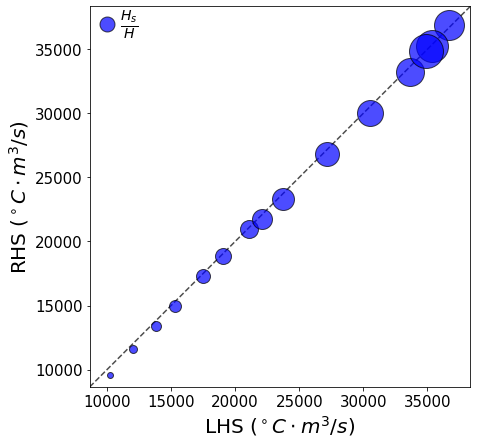

In [9]:
fig2, ax =plt.subplots(figsize=(10,7))


#ax.set(xlim=(3.1e4, 3.7e4), ylim=(3.1e4, 3.7e4))
ax.set(xlim=(1e4, 3.7e4), ylim=(1e4, 3.7e4))
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'LHS ($^\circ C\cdot m^3/s$)', size=20)
plt.ylabel(r'RHS ($^\circ C\cdot m^3/s$)', size=20)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
#loc_mark = [3.1e4, 3.7e4]
loc_mark = [1e4, 3.7e4]
plt.plot(loc_mark[0],loc_mark[1], marker='o', alpha=.7, ms=15, color='b', markeredgecolor='k')
#plt.text(loc_mark[0]+3e2, loc_mark[1]-1e2, r'$\frac{H_s}{H}$', fontsize=20)
plt.text(loc_mark[0]+1e3, loc_mark[1]-5e2, r'$\frac{H_s}{H}$', fontsize=20)
for j in range(len(Hs)):
    T1, T2, Qr, Qoc1, Qoc2, Toc1, Toc2 = TVEL(Hs[j])
    #LHS = T2 * (Qr+Qoc2)
    #RHS = Qr*T1+Qoc2*Toc2
    LHS = T1 * Qoc1
    RHS = Toc2 * Qoc2
    ax.plot(LHS, RHS, marker='o', alpha=.7, ms=2*(j+3), color='b', markeredgecolor='k')  

In [ ]:
fig3, ax =plt.subplots(figsize=(10,7))

R = np.empty(len(r))

for j in range(len(Hs)):
    T1, T2, Toc, Qr, Qoc = TVEL(Hs[j])
    R[j] = Qr/Qoc
    
      
ax.set_xlim([0,r[-1]])    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\frac{H_s}{H}$', size=20)
plt.ylabel(r'($^\circ C\cdot m^3/s$)', size=20)
ax.plot(r, R, 'o-k', lw=2, label=r'$\frac{Q_r}{Q_oc}$')
#ax.plot(r, Tin_f-Tout_f, 'o-', lw=2, label='dT')
ax.legend(loc = 'best', fontsize=15)

In [7]:
fig_path = "/Users/weiyangbao/Documents/Jupyter_Figs/Transport/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig2.savefig(fig_path + '/QocToc.png', dpi = 150, bbox_inches='tight')